## Nodes

changing Alice and Bob from generic simulation entities to Node components (describe i nterms of their network hardware)

In [4]:
import netsquid as ns
from netsquid.nodes import Node
alice = Node("Alice")

In [6]:
# if want to give Alice quantum memory
from netsquid.components import QuantumMemory
qmemory =  QuantumMemory("AliceMemory", num_positions=2)
alice.add_subcomponent(qmemory, name="memory1")
alice.subcomponents["memory1"]

QuantumMemory(name='AliceMemory')

In [11]:
# in general, any component can be added as a sub component of anotehr component 
# sub components and super component of a compnent can be queried as follows:
print(alice.subcomponents)
print(qmemory.supercomponent)
print(alice.supercomponent is None)

ConstrainedMap({'memory1': QuantumMemory(name='AliceMemory')})
Node(name='Alice')
True


For nodes there is a special treatment for the primary quantum memory (or quantum processor): it can be specified on initialization, and it can be accessed using the qmemory attribute. For instance:

In [12]:
qmemory = QuantumMemory("BobMemory", num_positions=2)
bob = Node("Bob", qmemory=qmemory)
bob.qmemory

QuantumMemory(name='BobMemory')

In [13]:
bob.subcomponents

ConstrainedMap({'BobMemory': QuantumMemory(name='BobMemory')})

Nodes, like any component, can have ports (Port). Because it is not possible to connect ports between components with different supercomponents (parents), a node’s ports serve as the external interface for all their sub-components. A node’s sub-component can communicate via a node’s ports via forwarding i.e. it can forward it’s output or receive forwarded input.

In [16]:
#any input to Alice's qin_charlie port will be forwarded asinput to her memoyr's qin port
# port forwarding is only setup in the setup diretion, unlike port connections
alice.add_ports(['qin_charlie'])
alice.ports['qin_charlie'].forward_input(alice.qmemory.ports['qin'])

## Connections

In [18]:
# define construction by subclassing from Connection base calss
# implementing message behavior for A and B ports
# A Channel has default ports send adn recv
# when message is put on input of connection (@ port A), it is fowarded to send port of Channel
# similar^ for output of the recv port is forwarded to port B
from netsquid.nodes.connections import Connection
from netsquid.components import ClassicalChannel
from netsquid.components.models import FibreDelayModel

class ClassicalConnection(Connection):
    def __init__(self, length):
        super().__init__(name="ClassicalConnection")
        self.add_subcomponent(ClassicalChannel("Channel_A2B", length = length, models = {"delay_model": FibreDelayModel()}))
        self.ports['A'].forward_input(
            self.subcomponents["Channel_A2B"].ports['send'])
        self.subcomponents["Channel_A2B"].ports['recv'].forward_output(self.ports['B'])

In [19]:
# alternative to subclassing is first instantiate Connection and then add and link teh channel subcomponent
# equal to above:

In [23]:
cconnection = Connection("ClassicalConnection")
cchannel = ClassicalChannel("Channel_A2B")
cconnection.add_subcomponent(cchannel, forward_input=[("A", "send")], forward_output=[("B", "recv")])
# could also add channel in opposite direction to make connection bi-direction
# to make connection bi-directional visit DirectConnection
# 

## Entangling connection for teleportation

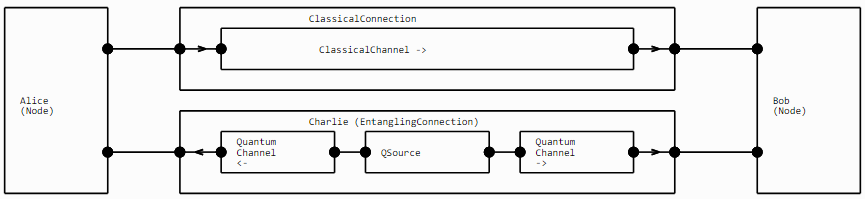

can represent Charlie form previous example as EntanglingConnection, that will contian the quantum source + Alice and Bob's quantum channels
<br>
s.t. internal clock in teh quantum source will auatomatically trigger this connection to generate entangled qubits and send them as output to its remote ports A and B via quantum channels

In [35]:
from netsquid.components.qchannel import QuantumChannel
from netsquid.qubits import StateSampler
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.components.models import FixedDelayModel, DepolarNoiseModel
import netsquid.qubits.ketstates as ks

class EntanglingConnection(Connection):
    
    def __init__(self, length, source_frequency):
        super().__init__(name="EntanglingConnection")
        timing_model = FixedDelayModel(delay=(1e9/source_frequency))
        qsource = QSource("qsource", StateSampler([ks.b00],[1.0]), num_ports=2, timing_model=timing_model, status=SourceStatus.INTERNAL)
        self.add_subcomponent(qsource)
        qchannel_c2a = QuantumChannel("qchannel_C2A", length=length/2, models={"delay_model": FibreDelayModel()})
        qchannel_c2b = QuantumChannel("qchannel_C2B", length=length/2, models={"delay_model": FibreDelayModel()})
        # adding channels and fowrading quantum channel output to export port output:
        self.add_subcomponent(qchannel_c2a, forward_output=[("A", "recv")])
        self.add_subcomponent(qchannel_c2b, forward_output=[("B", "recv")])
        # connecting qsource output to quantum channel input:
        qsource.ports["qout0"].connect(qchannel_c2a.ports["send"])
        qsource.ports["qout1"].connect(qchannel_c2b.ports["send"])

adding protoocl to this v useful bc simplifies complicated control-flows
<br> how to setup a network for teleportation compatible w using Protocols?
<br> end goal = adjusting this^ to create and return a 'Network" insetead of individual components

In [44]:
def example_network_setup(node_distance=4e3, depolar_rate=1e7):
    # setup nodes Alice and Bob with their respective quantum memories
    noise_model = DepolarNoiseModel(depolar_rate=depolar_rate)
    
    alice = Node(
        "Alice", 
        port_names = ['qin_charlie', 'cout_bob'],
        qmemory = QuantumMemory("AliceMemory",
                                num_positions = 2,
                                memory_noise_models = [noise_model]*2))
    bob = Node(
        "Bob",
        port_names = ['qin_charlie', 'cin_alice'],
        qmemory = QuantumMemory("BobMemory",
                                num_positions=2,
                               memory_noise_models = [noise_model]*2))
    
    bob.ports['qin_charlie'].forward_input(bob.qmemory.ports['qin0'])
    
    #setup classical connection bw nodes:
    c_conn = ClassicalConnection(length=node_distance)
    alice.ports['cout_bob'].connect(c_conn.ports['A'])
    bob.ports['cin_alice'].connect(c_conn.ports['B'])
    
    #setup entanglging connection bw nodes:
    q_conn = EntanglingConnection(length=node_distance,source_frequency=2e7)
    alice.ports['qin_charlie'].connect(q_conn.ports['A'])
    bob.ports['qin_charlie'].connect(q_conn.ports['B'])
    return alice, bob, q_conn, c_conn

In [45]:
# test part of our entwork by checkign after one cycle if entangled qubits have arrived on both quantum emories
ns.set_qstate_formalism(ns.QFormalism.DM)
alice, bob, *_ = example_network_setup()
stats = ns.sim_run(15)
qA, = alice.qmemory.peek(positions=[1])
qB, = bob.qmemory.peek(positions=[0])
qA, qB

(None, None)

In [46]:
fidelity = ns.qubits.fidelity([qA, qB], ns.b00)
pritn(f"Entangled fidelity (after 5 ns wait) = {fidelity:.3f}")

ValueError: [None, None] is not a valid list of qubit(s)